In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input as effnet_preprocess
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
# Funcție pentru împărțirea datasetului
def tf_split_data(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=1000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=10)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_set = ds.take(train_size)
    val_set = ds.skip(train_size).take(val_size)
    test_set = ds.skip(train_size).skip(val_size)

    return train_set, val_set, test_set

In [3]:
# Dimensiunea imaginilor
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 5

In [4]:
# Încărcarea datasetului
tf_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "diamonds",  
    seed=41,
    shuffle=True,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)
train_ds, val_ds, test_ds = tf_split_data(tf_dataset)

Found 14078 files belonging to 8 classes.


In [5]:
# EfficientNet Model - versiunea 2 OK
base_model = EfficientNetB0(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), include_top=False, weights='imagenet')
base_model.trainable = True  # Fine-tuning - Dezgheață straturile superioare
for layer in base_model.layers[:-20]:
    layer.trainable = False  # Păstrează congelate straturile de bază
base_model.trainable = False  # Transfer learning - congelăm straturile inițiale

In [6]:
# Crearea modelului EfficientNet - versiunea 2 OK
inputs = layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = layers.RandomFlip("horizontal")(inputs)  # Augmentare pentru generalizare
x = layers.RandomRotation(0.2)(x)
x = layers.RandomZoom(0.1)(x)
x = layers.Rescaling(1./255)(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.6)(x)
x = layers.Dense(len(tf_dataset.class_names), activation='softmax')(x)
model_efficientnet = models.Model(inputs, x)

model_efficientnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#model_efficientnet.build(input_shape=input_shape)
model_efficientnet.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip (RandomFlip)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation (RandomRotation)     │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom (RandomZoom)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_2 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,380,587 (16.71 MB)

 Trainable params: 330,504 (1.26 MB)

 Non-trainable params: 4,050,083 (15.45 MB)

In [7]:
# Vision Transformer (ViT) Model Versiunea 2 - FUNCTIONALA
import os
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
import shutil

# Define the URL for the Vision Transformer model
vit_url = "https://tfhub.dev/sayakpaul/vit_b16_fe/1"

# Clear previous TFHub cache
shutil.rmtree("/tmp/tfhub_cache", ignore_errors=True)
os.environ["TFHUB_CACHE_DIR"] = "/tmp/tfhub_cache"

# Load Vision Transformer layer from TensorFlow Hub
vit_layer = hub.KerasLayer(vit_url, trainable=False)

# Define input image size
IMG_SIZE = (224, 224)

# Define input layer
inputs = keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

# Resize and normalize the input image
x = keras.layers.Resizing(224, 224)(inputs)
x = keras.layers.Rescaling(1./127.5, offset=-1)(x)

# Using Lambda layer to apply Vision Transformer
def apply_vit(x):
    return vit_layer(x)

vit_outputs = keras.layers.Lambda(apply_vit)(x)

# Define output layer
outputs = keras.layers.Dense(12, activation='softmax')(vit_outputs)

# Create model
model_vit = keras.Model(inputs=inputs, outputs=outputs)

# Compile model
model_vit.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#model_vit.build(input_shape=input_shape)
# Display model summary
model_vit.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resizing (Resizing)                  │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_3 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 12)                  │           9,228 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,228 (36.05 KB)

 Trainable params: 9,228 (36.05 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Antrenare EfficientNet
history_effnet = model_efficientnet.fit(train_ds, validation_data=val_ds, epochs=5)
model_efficientnet.save("efficientnet.keras")

Epoch 1/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 543s 1s/step - accuracy: 0.1350 - loss: 2.3408 - val_accuracy: 0.1499 - val_loss: 2.0897
Epoch 2/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 509s 1s/step - accuracy: 0.1551 - loss: 2.1608 - val_accuracy: 0.1300 - val_loss: 2.1296
Epoch 3/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 479s 1s/step - accuracy: 0.1719 - loss: 2.0861 - val_accuracy: 0.1392 - val_loss: 2.6613
Epoch 4/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 476s 1s/step - accuracy: 0.1725 - loss: 2.0609 - val_accuracy: 0.1344 - val_loss: 2.5759
Epoch 5/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 474s 1s/step - accuracy: 0.1729 - loss: 2.0388 - val_accuracy: 0.1250 - val_loss: 2.1241


In [9]:
# Antrenare ViT
history_vit = model_vit.fit(train_ds, validation_data=val_ds, epochs=3)
model_vit.save("vit.keras")

Epoch 1/3
352/352 ━━━━━━━━━━━━━━━━━━━━ 5973s 17s/step - accuracy: 0.8389 - loss: 0.5469 - val_accuracy: 0.9986 - val_loss: 0.0226
Epoch 2/3
352/352 ━━━━━━━━━━━━━━━━━━━━ 6054s 17s/step - accuracy: 0.9949 - loss: 0.0314 - val_accuracy: 0.9950 - val_loss: 0.0317
Epoch 3/3
352/352 ━━━━━━━━━━━━━━━━━━━━ 6007s 17s/step - accuracy: 0.9978 - loss: 0.0195 - val_accuracy: 0.9972 - val_loss: 0.0184


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

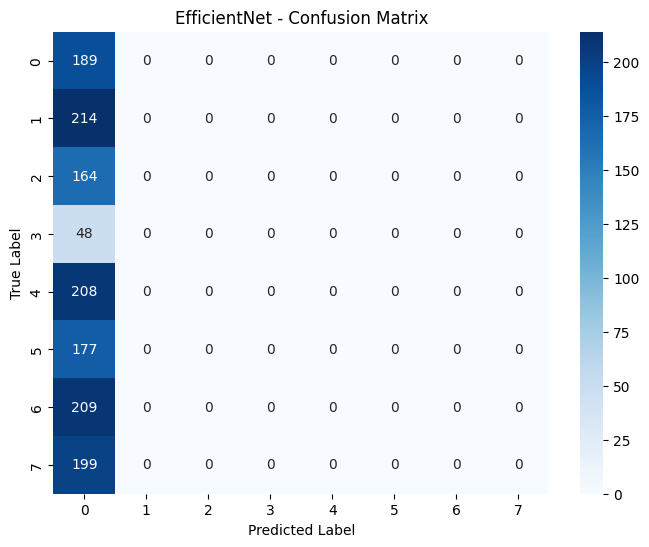

In [10]:
# Testare EfficientNet
y_true = []
y_pred = []
for images, labels in test_ds:
    preds = model_efficientnet.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("EfficientNet - Confusion Matrix")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

C:\Users\Savin Cristian U\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Savin Cristian U\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Savin Cristian U\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

              precision    recall  f1-score   support

     Class 0       0.13      1.00      0.23       183
     Class 1       0.00      0.00      0.00       186
     Class 2       0.00      0.00      0.00       188
     Class 3       0.00      0.00      0.00        50
     Class 4       0.00      0.00      0.00       196
     Class 5       0.00      0.00      0.00       196
     Class 6       0.00      0.00      0.00       195
     Class 7       0.00      0.00      0.00       214

    accuracy                           0.13      1408
   macro avg       0.02      0.12      0.03      1408
weighted avg       0.02      0.13      0.03      1408



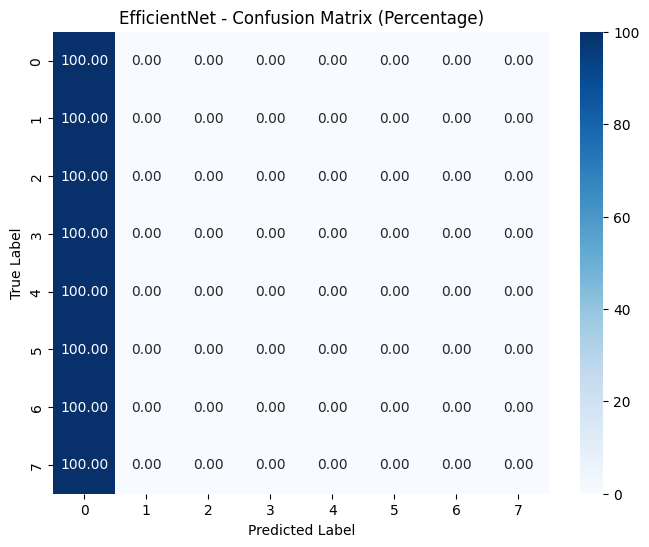

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Presupunem că testarea este deja făcută
y_true = []
y_pred = []
for images, labels in test_ds:
    preds = model_efficientnet.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Matrice de confuzie
conf_matrix = confusion_matrix(y_true, y_pred)

# Normalizare pe rânduri (procentual față de fiecare clasă reală)
conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

num_classes = len(np.unique(y_true))
class_names = [f"Class {i}" for i in range(num_classes)]
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=class_names))

# Afișare heatmap cu procente
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("EfficientNet - Confusion Matrix (Percentage)")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
1/1 ━━━━━━━━

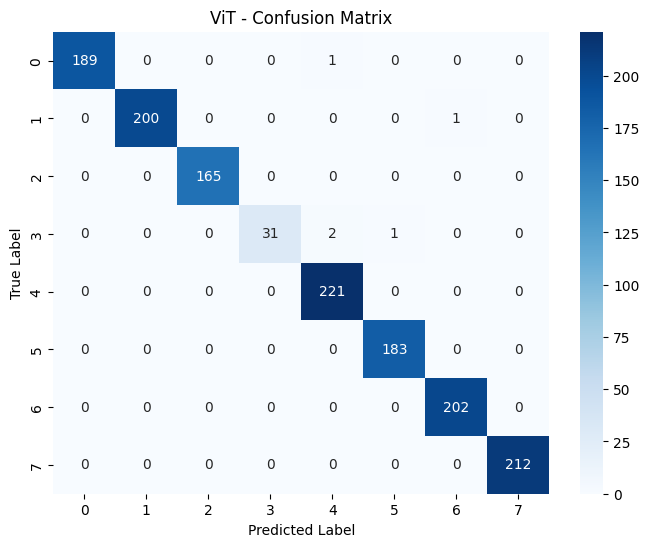

In [14]:
# Testare ViT
y_true = []
y_pred = []
for images, labels in test_ds:
    preds = model_vit.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("ViT - Confusion Matrix")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
1/1 ━━━━━━━━

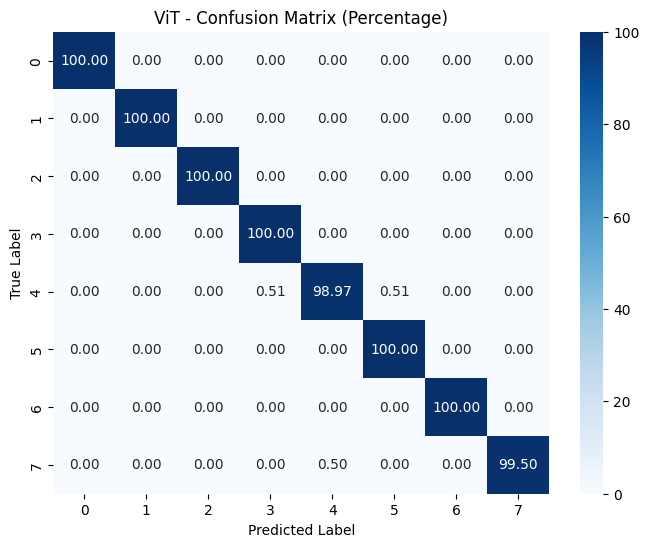

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Colectare predicții și etichete reale
y_true = []
y_pred = []
for images, labels in test_ds:
    preds = model_vit.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Matrice de confuzie
conf_matrix = confusion_matrix(y_true, y_pred)

# Conversie în procente față de totalul pe fiecare clasă reală
conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

num_classes = len(np.unique(y_true))
class_names = [f"Class {i}" for i in range(num_classes)]
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=class_names))

# Afișare heatmap procentual
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("ViT - Confusion Matrix (Percentage)")
plt.show()

In [16]:
# Funcție pentru afișarea graficelor de antrenare
def plot_training_history(history, title):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

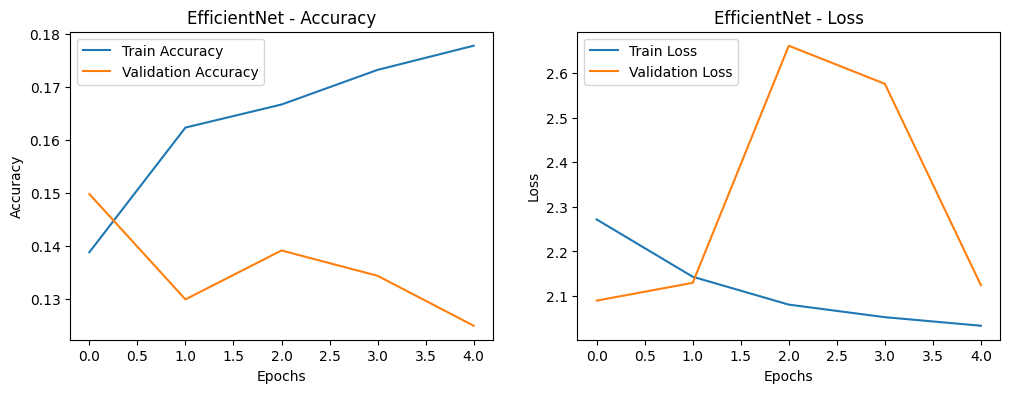

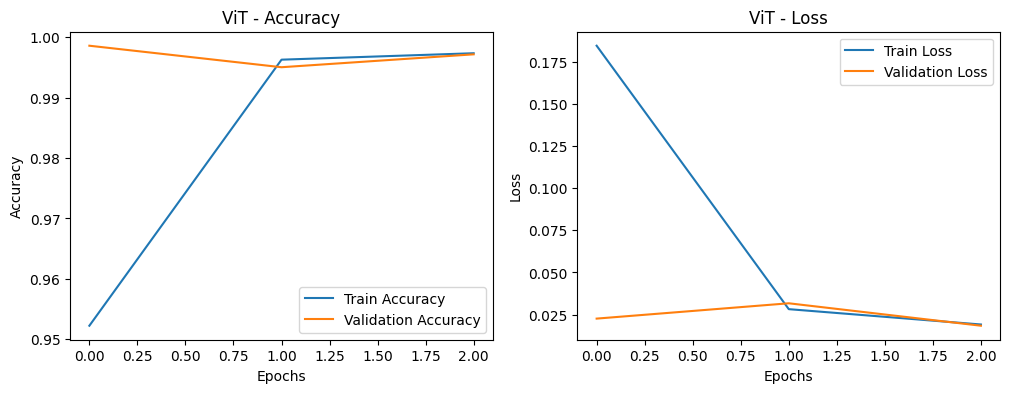

In [17]:
# Afișare grafice antrenare
plot_training_history(history_effnet, "EfficientNet")
plot_training_history(history_vit, "ViT")